# 평가  
- 분류에 사용되는 성능 평가 지표에 대해 자세히 알아볼 예정 (특히 이진 분류)  
- 분류의 성능평가지표  
1) 정확도(Accuracy)  
2) 오차행렬(Confusion Matrix)  
3) 정밀도(Precision)  
4) 재현율(Recall)  
5) F1 스코어  
6) ROC AUC  

## 정확도(Accuracy)  
* 정확도 : 실제 데이터에서 예측 데이터가 얼마나 같은지를 판단하는 지표.  
정확도(Accuracy) = 예측 결과가 동일한 데이터 건수 / 전체 예측 데이터 건수.  
* 정확도는 직관적으로 모델 예측 성능을 나타내는 평가 지표.  
* 하지만 이진 분류의 경우 데이터의 구성에 따라 ML 모델의 성능을 왜곡할 수 있기 때문에 정확도만으로 성능을 평가하지 않음.  
* 예를 들어 타이타닉의 생존 예측 결과를 보면 여자가 생존 확률이 더 높았기 때문에 아무런 ML 모델을 사용하지 않고 여자는 생존하고 남자는 생존하지 않는다고 예측해도 ML모델을 사용했을 경우의 정확도와 비슷하게 나올 수 있음.

In [74]:
from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음.
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면(남자) 0(사망), 그렇지 않으면(여자) 1(생존)로 에측함.
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [75]:
# 지금까지 피처를 가공한 내역을 정리, 함수로 만들어 쉽게 재사용할 수 있도록 만들기
# Null처리 함수
from sklearn import preprocessing

def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
        
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    
    return df

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용해 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는 : {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는 : 0.7877


단순한 알고리즘으로도 데이커 구성에 따라 정확도는 78%로 꽤 높은 수치가 나올 수 있음. 따라서 정확도는 불균형한 레이블값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님.  <br><br>
[MNIST 데이터를 이용하여 이진 분류의 경우 정확도 평가 적용시 어떤 문제가 발생하는지 알아보기]  
* 원래 MNIST 데이터는 레이블값이 0부터 9까지의 멀티 레이블.  
* 레이블 값이 7인 것만 True, 나머지는 False로 변환해 이진분류 데이터로 변환 -> 즉 10%만 True

In [77]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환.
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

# 불균형한 레이블 데이터 분포도 확인.
print("레이블 테스트 세트 크기 : ", y_test.shape)
print("테스트 세트 레이블 0과 1의 분포도")
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는 : {:.3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 :  (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 : 0.900


정확도가 가지는 불균형한 레이블은 가진 데이터에서의 한계점을 극복하기 위해 여러 가지 분류 지표와 함께 적용해야 함.  
## 오차 행렬  
* 이진 분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지를 함께 나타내는 지표.  
* 오차 행렬은 4분면 행렬에서 실제 레이블 클래스 값과 예측 레이블 클래스 값이 어떠한 유형을 가지고 매핑되는지를 나타냄.  
<img src = "https://i.imgur.com/IUrBHiD.png">  
<t>* TN : 예측값과 실제값이 모두 0(Negative).  </t><br>
<t>* FP : 예측값은 1(Positive)이지만 실제값은 0(Negative).</t><br>
<t>* FN : 예측값은 0(Negative)이지만 실제값은 1(Positive).</t><br>
<t>* FP : 예측값과 실제값이 모두 1(Positive).</t>  
* 사이킷런에서는 오차 행렬을 구하기 위해 confusion_matrix()를 제공.  

In [78]:
# 위 예제인 MyFakeClassifier의 예측 결과인 fakepred와 실제 결과인 y_test를 confusion_matrix()를 이용해 오차 행렬을 배열 형태로 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

* TP, FP, FN, TP 값들을 조합해 Classifier의 성능을 측정할 수 있는 주요 지표인 정확도(Accuracy), 정밀도(Precision), 재현율(Recall)값을 알 수 있음.  
* 정확도 : 예측값과 실제값이 얼마나 동일한가 -> True에 해당하는 값인 TN, TP에 좌우됨.  
<t> 정확도 = 예측 결과와 실제 값이 동일한 건수/전체 데이터 수 = (TN + TP) / (TN + FP + FN + TP) </t><br><br>

## 정밀도와 재현율  
* 정밀도  
1) 예측을 Positive로 한 대상 중에서 예측과 실제 값이 Positive로 일치한 데이터의 비율  
2) 정밀도 = TP / (FP + TP)  
3) TP는 높이고 FP를 낮추는데 초점을 맞춰야 함.  
4) Negative인 값을 Positive로 예측했을 때 업무상 큰 영향이 발생하는 경우에 정밀도가 주요 지표가 됨.  
<t> ex : 스팸 메일 예측의 경우 스팸 메일이 아닌 메일을 스팸 메일로 예측해 차단해버리는 경우 사용자는 일반 메일을 받지 못하게 됨.</t><br>
5) 사이킷런에서는 precision_score() API를 제공.  


* 재현율  
1) 실제 값이 Positive인 대상 중에 에측과 실제 값이 Positive로 일치한 데이터의 비율.  
2) 재현율 = TP / (FN + TP)  
3) TP는 높이고 FN은 낮추는데 초점을 맞춰야 함.  
4) Positive인 값을 Negative로 잘못 예측했을 때 업무상 큰 영향이 발생하는 경우에 재현율이 주요 지표가 됨.  
<t> ex1 : 암 판단 모델의 경우 양성을 음성으로 예측하는 경우 환자의 생명에 지장이 생길 수 있음. </t><br>
<t> ex2 : 보험 사기와 같은 금융 사기 적발 모델도 사기 모델을 일반 모델로 잘못 예측하면 금융 회사와 사용자 모두에게 큰 피해를 입힐 수 있음.</t>
5) 사이킷런에서는 recall_score() API를 제공.

<br>
[로지스틱 회귀를 기반으로 타이타닉 생존자를 예측하고 confusion matrix, accuracy, precision, recall 평가 수행하기]

In [107]:
# confusion_matrix, accuracy, precision, recall 평가를 한꺼번에 호출하는 get_clf_eval() 함수 만들기
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test,pred)
    print("오차 행렬")
    print(confusion)
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}".format(accuracy, precision, recall))

In [81]:
# 학습/예측/평가
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할.
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=11)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


C:\Users\eh063\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### 정밀도/재현율 트레이드오프  
* 정밀도/재현율의 트레이드오프 :  정밀도와 재현율을 서로 상호보완적. 따라서 둘 중 하나를 강제로 높이게 되면 다른 한쪽의 수치가 떨어지기 쉬움.  
* 사이킷런의 분류 알고리즘은 예측 데이터가 어떤 특정 레이블에 속하는지 계산하기 위해 개별 레이블별로 결정 확률을 구함. 사이킷런은 개별 데이터별로 예측 확률을 반환하는 predict_proba() 메서드를 제공.  
* predict_proba()  
1) 학습이 완료된 사이킷런 Classifier 객체에서 호출이 가능.  
2) 입력 파라미터 : 테스트 피처 데이터 세트.  
3) 반환값 : 테스트 피처 레코드의 개별 클래스 예측 확률.

In [82]:
# 타이타닉 생존자 데이터를 학습한 LogisticRegression 객체에서 predict_proba() 수행
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_roba()결과 : Shape : {0}".format(pred_proba.shape))
print("pred_proba array에서 앞 3개만 샘플로 추출 : \n", pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1, 1)], axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n", pred_proba_result[:3])

pred_roba()결과 : Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 : 
 [[0.44935226 0.55064774]
 [0.86335512 0.13664488]
 [0.86429644 0.13570356]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935226 0.55064774 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429644 0.13570356 0.        ]]


* predict()는 predict_proba() 호출 결과로 반환된 배열에서 분류 결정 임계값보다 큰 값이 들어 있는 칼럼의 위치를 받아 최종적으로 예측 클래스를 결정함.  
* 사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있음.  <br><br>

[분류 결정 임곗값으로 정밀도와 재현율을 조정하는 로직을 Binarizer 클래스를 이용해 구현해보기]  
Binarizer 클래스 :  fit_transform()을 이용하여 정해진 threshold(임곗값) 보다 같거나 작으면 0, 크면 1로 변환하여 반환  

In [83]:
from sklearn.preprocessing import Binarizer

X = [[1, -1, 2], 
     [2, 0, 0], 
     [0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [84]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임.
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705


In [85]:
# Binarizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗값을 0.5에서 0.4로 낮춤
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197


[임곗값을 낮췄을 때 정밀도는 떨어지고 재현율이 올라가는 이유]  
* 임곗값을 낮추게 되면 True로 예측될 확률이 많아짐 -> TP, FP 값이 늘어나고 TN, FN 값이 줄어들면서 재현율이 높아지게 됨.  

In [108]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장.
thresholds = [0.4, 0.45, 0.5 ,0.55, 0.6]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds lit 객체 내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임곗값 : ", custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값 :  0.4
오차 행렬
[[80 20]
 [17 37]]
정확도 : 0.7597, 정밀도 : 0.6491, 재현율 : 0.6852
임곗값 :  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667
임곗값 :  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111
임곗값 :  0.55
오차 행렬
[[91  9]
 [23 31]]
정확도 : 0.7922, 정밀도 : 0.7750, 재현율 : 0.5741
임곗값 :  0.6
오차 행렬
[[91  9]
 [26 28]]
정확도 : 0.7727, 정밀도 : 0.7568, 재현율 : 0.5185


* precision_recall_curve()  
1) 임곗값 변화에 따른 평가 지표 값을 알아볼 때 사용하는 사이킷런 API  
2) 입력 파라미터 : y_true - 실제 클래스값 배열, probas_pred - Positive 칼럼의 예측 확률 배열
3) 반환값 : 정말도 - 정밀도 값을 배열로 반환, 재현율 - 임곗값별 재현율 값을 배열로 반환.

In [87]:
# precision_recall_curve()를 사용하여 타이타닉 예측 모델의 임곗값별 정밀도와 재현율 구해보기
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추측
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

# 실젯값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print("반환된 분류 결정 임곗값 배열의 Shape:", thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출.
thr_index = np.arange(0, thresholds.shape[0], 15)
print("샘플 추출을 위한 임계값 배열의 index 10개 : ", thr_index)
print("샘플용 10개의 임곗값 : ", np.round(thresholds[thr_index], 2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print("샘플 임계값별 정밀도 : ", np.round(precisions[thr_index], 3))
print("샘플 임계값별 재현율 : ", np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (147,)
샘플 추출을 위한 임계값 배열의 index 10개 :  [  0  15  30  45  60  75  90 105 120 135]
샘플용 10개의 임곗값 :  [0.12 0.13 0.15 0.17 0.26 0.38 0.49 0.63 0.76 0.9 ]
샘플 임계값별 정밀도 :  [0.379 0.424 0.455 0.519 0.618 0.676 0.797 0.93  0.964 1.   ]
샘플 임계값별 재현율 :  [1.    0.967 0.902 0.902 0.902 0.82  0.77  0.656 0.443 0.213]


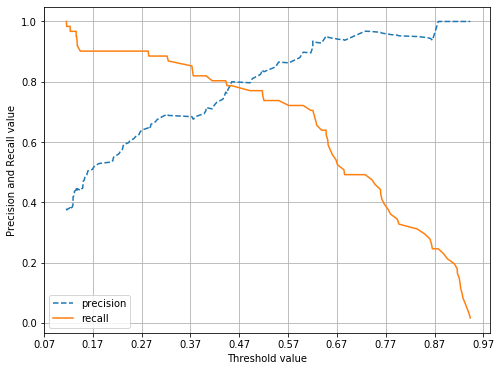

In [88]:
# 정밀도와 재현율 곡선 시각화
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축을 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8, 6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold값 X축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel("Threshold value")
    plt.ylabel("Precision and Recall value")
    plt.legend()
    plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])

임곗값을 증가하면 정밀도는 증가하고 재현율은 감소하는 모습을 보임.  

## F1 스코어  
* F1 스코어는 정밀도와 재현율을 결합한 지표.  
* F1 스코어는 정밀도와 재현율이 어느 한쪽으로 치우치지 않는 수치를 나타낼 때 상대적으로 높은 값을 가짐.  
* 사이킷런에서는 f1_score() API 제공.

In [89]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print("F1 스코어 : {0:.4f}".format(f1))

F1 스코어 : 0.7966


In [90]:
# 타이타닉 생존자 예측에서 임계값을 변화시키며 F1 스코어를 포함한 평가지표 구해보기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print("오차 행렬")
    print(confusion)
    # f1 score print 추가
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}".format(accuracy, precision, recall, f1))
    
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값 :  0.4
오차 행렬
[[97 21]
 [11 50]]
정확도 : 0.8212, 정밀도 : 0.7042, 재현율 : 0.8197, F1 : 0.7576
임곗값 :  0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도 : 0.8547, 정밀도 : 0.7869, 재현율 : 0.7869, F1 : 0.7869
임곗값 :  0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도 : 0.8659, 정밀도 : 0.8246, 재현율 : 0.7705, F1 : 0.7966
임곗값 :  0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도 : 0.8715, 정밀도 : 0.8654, 재현율 : 0.7377, F1 : 0.7965
임곗값 :  0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도 : 0.8771, 정밀도 : 0.8980, 재현율 : 0.7213, F1 : 0.8000


## ROC 곡선과 AUC  
* ROC 곡선과 이에 기반한 AUC 스코어는 이진 분류의 예측 성능 측정에서 중요하게 사용되는 지표임.  
* ROC 곡선은 FPR(False Positive Rate)이 변할 때 TPR(True Positive Rate)의 변화율을 나타낸 곡선.  
1) TPR : 재현율  
2) FPR : FP / (FP + TN)  
<img src = "https://t1.daumcdn.net/cfile/tistory/9931DF445B94D81A07">  <br>
* 가운데 직선은 ROC 곡선의 최저값. -> ROC 곡선이 직선에 가까울수록 성능이 좋지 않고, 멀수록 성능이 좋음.  
* ROC 곡선은 FPR을 0부터 1까지 변경하면서 TPR의 변화값을 구함. -> FPR을 변경하는 방법 : 분류 결정 임곗값 변경하기  
1) FPR을 0으로 만드는 방법 : 임곗값 1로 지정하기 
<t> 임곗값을 1로 지정하게 되면 임곗값보다 높은 확률을 가진 데이터를 Positive으로 예측할 수 없기 때문에 FP가 0이 됨.</t><br>
2) FPR을 1로 만드는 방법 : TN을 0으로 만들기    
<t> TN을 0으로 만들기 위해서는 임계값이 0이어야 함. TN이 0이면 모두 Positive로 예측되기 때문에 FP가 1이 됨.</t><br>
* 사이킷런은 ROC 곡선을 구하기 위해 roc_curve() API 제공함.

In [91]:
# roc_curve()를 이용해 타이타닉 생존자 예측 모델의 FPR, TPR, 임곗값 구해보기.
from sklearn.metrics import roc_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건이므로 샘플로 10건만 추출하되, 임곗값을 5 Step으로 추출.
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)

print("샘플 추출을 위한 임곗값 배열의 index 10개 : ", thr_index)
print("샘플용 10개의 임곗값 : ", np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임계값에 따른 FPR, TPR값
print("샘플 임곗값별 FPR : ", np.round(fprs[thr_index], 3))
print("샘플 임곗값별 TPR : ", np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index 10개 :  [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임곗값 :  [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR :  [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR :  [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


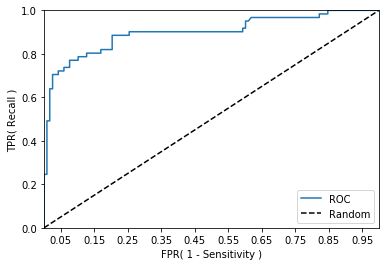

In [92]:
# ROC 곡선 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환받음.
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림.
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림.
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y축명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("FPR( 1 - Sensitivity )")
    plt.ylabel("TPR( Recall )")
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:, 1])

* ROC 곡선 자체는 FPR과 TPR의변화 값을 보는데 이용하고 분류의 성능 지표로 사용되는 것은 ROC 곡선 면적에 기반한 AUC 값으로 결정함.  
* AUC(Area Under Curve)값은 ROC 곡선 밑의 면적을 구한 것. 1에 가까울수록 좋은 수치

In [111]:
# get_clf_eval() 함수에 ROC AUC 값을 측정하는 로직 추가
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차 행렬")
    print(confusion)
    # ROC-AUC print 추가
    print("정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}".
          format(accuracy, precision, recall, f1, roc_auc))

## 피마 인디언 당뇨병 예측  

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [95]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [96]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출.
# 맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도 : 0.7727, 정밀도 : 0.7111, 재현율 : 0.5926, F1 : 0.6465, AUC : 0.8083


C:\Users\eh063\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


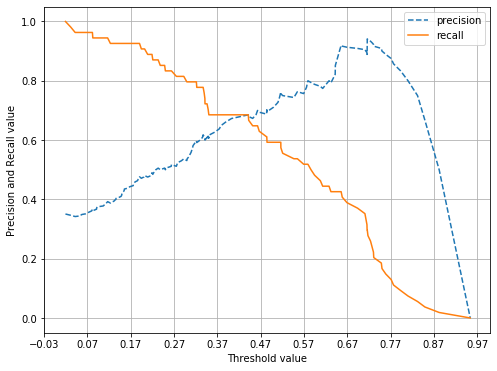

In [97]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

임곗값을 0.42로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞춤. 하지만 재현율과 정밀도 모두 0.7도 안 되는 수치를 보임

In [98]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min값이 0으로 돼 있는 피처가 상당히 많음. 

(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

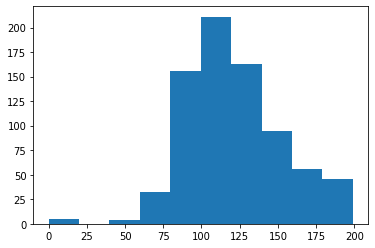

In [99]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [100]:
# 0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print("{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %".format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [101]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [102]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111, F1 : 0.6804, AUC : 0.8433


C:\Users\eh063\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [109]:
# 분류 결정 임곗값을 변화시키면서 재현율 값의 성능 수치가 어느 정도나 개선되는지 확인해 보기.
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)

임곗값 :  0.3
오차 행렬
[[65 35]
 [11 43]]
정확도 : 0.7013, 정밀도 : 0.5513, 재현율 : 0.7963
임곗값 :  0.33
오차 행렬
[[71 29]
 [11 43]]
정확도 : 0.7403, 정밀도 : 0.5972, 재현율 : 0.7963
임곗값 :  0.36
오차 행렬
[[76 24]
 [15 39]]
정확도 : 0.7468, 정밀도 : 0.6190, 재현율 : 0.7222
임곗값 :  0.39
오차 행렬
[[78 22]
 [16 38]]
정확도 : 0.7532, 정밀도 : 0.6333, 재현율 : 0.7037
임곗값 :  0.42
오차 행렬
[[84 16]
 [18 36]]
정확도 : 0.7792, 정밀도 : 0.6923, 재현율 : 0.6667
임곗값 :  0.45
오차 행렬
[[85 15]
 [18 36]]
정확도 : 0.7857, 정밀도 : 0.7059, 재현율 : 0.6667
임곗값 :  0.48
오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481
임곗값 :  0.5
오차 행렬
[[90 10]
 [21 33]]
정확도 : 0.7987, 정밀도 : 0.7674, 재현율 : 0.6111


In [112]:
# 임곗값을 0.48로 낮춘 후 다시 예측해보기
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환.
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도 : 0.7987, 정밀도 : 0.7447, 재현율 : 0.6481, F1 : 0.6931, AUC : 0.8433


## 정리  
* 분류에 사용되는 성능 평가 지표 : 정확도, 오차 행렬, 정밀도, 재현율, F1 스코어, ROC-AUC  
* 이진 분류의 경우 label값이 불균형하면 정확도 만으로는 성능을 평가할 수 없음.  
* 오차 행렬 : Negative와 Positive값을 가지는 실제 클래스 값과 예측 클래스 값이 True, False에 따라 TN, FP, FN, TP로 매핑되는 4가지 행렬을 기반으로 예측 성능을 평가함.  
* 정확도, 정밀도, 재현율 수치는 TN, FP, FN, TP를 결합하여 만들어짐.  
* 정밀도와 재현율을 Positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표.  
* 분류하려는 업무의 특성상 정밀도나 재현율이 특별히 강조돼야 할 경우 분류의 결정 임곗값(threshold)을 조정해 정밀도나 재현율의 값을 높일 수 있음.  
* F1 스코어 : 정밀도와 재현율을 결합한 평가 지표, 정밀도와 재현율이 어느 한쪽으로 치우치지 않을 때 높은 지표값을 가지게 됨.  
* AUC값 : ROC 곡선 밑의 면적, 1에 가까울수록 좋은 수치.